# Basics: Aggregation, filtering, limits

Now that you have ibis installed and connecting to your Impala, let's get our feet wet.

In [1]:
import ibis
import os
hdfs_port = os.environ.get('IBIS_WEBHDFS_PORT', 50070)
hdfs = ibis.hdfs_connect(host='impala', port=hdfs_port)
con = ibis.impala.connect(host='impala', database='ibis_testing',
                          hdfs_client=hdfs)

## Accessing an Impala table

The optional `database` paramter allows to fully qualify the table.

In [2]:
table = con.table('functional_alltypes')
table = con.table('functional_alltypes', database='ibis_testing')

## Column selection and basic expressions

Selecting columns from a table works just like pandas

In [3]:
col = table.double_col

# alternately
col2 = table['bigint_col']

Table columns are equipped with a variety of math operations and other methods to assist in writing your analytics. For example:

In [4]:
expr = col.log2() - 1

Some operations transform arrays to arrays, while others aggregate, like `sum` and `mean`:

In [5]:
expr2 = expr.sum()

The methods that are available on columns depend on the type of the column. For example, you won't see the `substr` or `upper` methods for strings on numeric columns:

In [6]:
substr_expr = table.string_col.upper().substr(0, 2)

Notice that printing the expressions to the console does not actually do anything, and shows a graphical representation of the expression you've built.

**Note: don't worry too much about the details of the expression tree that's outputted, it's very likely to change over time**

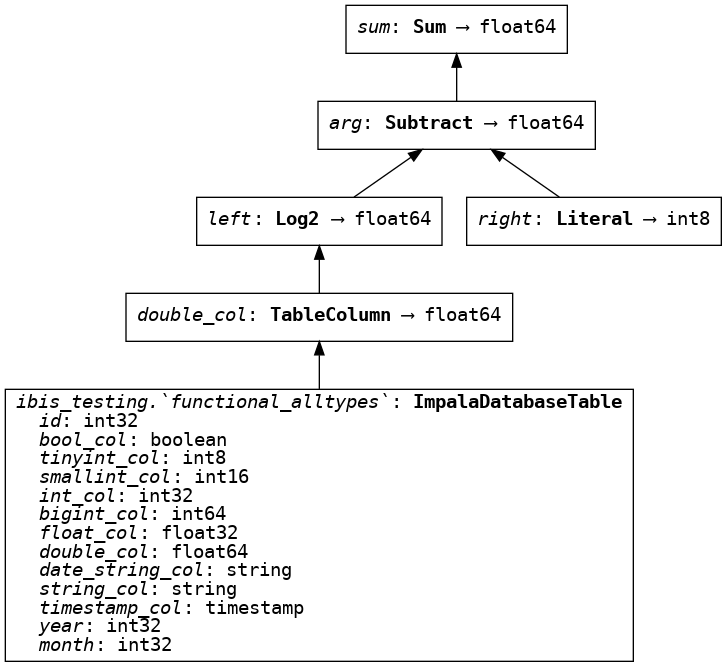

In [7]:
expr2

We can also execute an expression by calling `execute` on the Impala connection object

In [8]:
con.execute(col.sum())

331785.00000000006

There's a shortcut to make this a little more convenient in interactive use

## Interactive mode


Many Ibis expressions can be immediately executed against the database, and it may improve your productivity to have the executed for you whenever you try to print the expression in the console / IPython notebook.

To do this, we have an *interactive* mode available, which can be turned on/off like so:

In [9]:
ibis.options.interactive = True

Now, any expressions you write will be executed right away

In [10]:
table.limit(10)

     id  bool_col  tinyint_col  smallint_col  int_col  bigint_col  float_col  \
0  5770      True            0             0        0           0        0.0   
1  5771     False            1             1        1          10        1.1   
2  5772      True            2             2        2          20        2.2   
3  5773     False            3             3        3          30        3.3   
4  5774      True            4             4        4          40        4.4   
5  5775     False            5             5        5          50        5.5   
6  5776      True            6             6        6          60        6.6   
7  5777     False            7             7        7          70        7.7   
8  5778      True            8             8        8          80        8.8   
9  5779     False            9             9        9          90        9.9   

   double_col date_string_col string_col           timestamp_col  year  month  
0         0.0        08/01/10          

You can select a row range with slicing syntax:

In [11]:
table.double_col.sum()

331785.00000000006

Don't worry about the syntax here, but expressions resulting in tabular output will come back as a pandas DataFrame by default:

In [12]:
metrics = [table.double_col.sum().name('total')]
expr = table.group_by('string_col').aggregate(metrics)
expr

  string_col    total
0          9  66357.0
1          3  22119.0
2          6  44238.0
3          4  29492.0
4          1   7373.0
5          8  58984.0
6          2  14746.0
7          7  51611.0
8          5  36865.0
9          0      0.0

## Verbose mode and logging


You may want to see or log all the Impala queries that Ibis executes under the hood. To do that, use the `options.verbose` option:

In [13]:
ibis.options.verbose = True

metrics = [table.double_col.sum().name('total')]
expr = table.group_by('string_col').aggregate(metrics)
expr

SELECT `string_col`, sum(`double_col`) AS `total`
FROM ibis_testing.`functional_alltypes`
GROUP BY 1
LIMIT 10000


  string_col    total
0          9  66357.0
1          3  22119.0
2          6  44238.0
3          4  29492.0
4          1   7373.0
5          8  58984.0
6          2  14746.0
7          7  51611.0
8          5  36865.0
9          0      0.0

In [14]:
queries = []
def logger(x):
    queries.append(x)
    
ibis.options.verbose_log = logger

expr.execute()
expr.execute()

queries

['SELECT `string_col`, sum(`double_col`) AS `total`\nFROM ibis_testing.`functional_alltypes`\nGROUP BY 1\nLIMIT 10000',
 'SELECT `string_col`, sum(`double_col`) AS `total`\nFROM ibis_testing.`functional_alltypes`\nGROUP BY 1\nLIMIT 10000']

In [15]:
ibis.options.verbose_log = print
ibis.options.verbose = False

Aggregation basics
---

One of the essential table API functions is `aggregate`. Aggregation involves the following

- One or more *named* aggregate expressions, or *reductions*
- Zero or more grouping expressions or column names

This ends up working very similarly to pandas's **groupby** mechanism.

Let's start with a simple reduction:

In [16]:
metric = table.double_col.sum()

As you saw above, you can execute this immediately and obtain a value:

In [17]:
metric

331785.00000000006

The reduced column can be more complex; for example, you could count the number of null values in a column like so:

In [18]:
table.double_col.isnull().sum()

0

To aggregate a table, potentially with grouping keys, we have to give the reduction a name and call `aggregate`

In [19]:
metric = metric.name('double_total')
expr = table.aggregate([metric])
result = con.execute(expr)
result

,double_total
0,331785.0


The result here is actually a pandas DataFrame with 1 row and just the one column. We can add another metric and add a grouping key

In [20]:
metric2 = (table.bigint_col + 1).log10().max().name('some_metric')

expr = table.aggregate([metric, metric2], by=['string_col'])
expr

  string_col  double_total  some_metric
0          9       66357.0     1.959041
1          3       22119.0     1.491362
2          6       44238.0     1.785330
3          4       29492.0     1.612784
4          1        7373.0     1.041393
5          8       58984.0     1.908485
6          2       14746.0     1.322219
7          7       51611.0     1.851258
8          5       36865.0     1.707570
9          0           0.0     0.000000

We provide a convenience `group_by`, a la pandas, to make this a little more composable:

In [21]:
expr = (table.group_by('string_col')
        .aggregate([metric, metric2]))
expr

  string_col  double_total  some_metric
0          9       66357.0     1.959041
1          3       22119.0     1.491362
2          6       44238.0     1.785330
3          4       29492.0     1.612784
4          1        7373.0     1.041393
5          8       58984.0     1.908485
6          2       14746.0     1.322219
7          7       51611.0     1.851258
8          5       36865.0     1.707570
9          0           0.0     0.000000

You can also group by named column expressions

In [22]:
keys = [table.timestamp_col.hour().name('hour'), 'string_col']

expr = table.group_by(keys).aggregate([metric])

# Top 10 by double_total, more on this later
expr.sort_by([('double_total', False)]).limit(10)

   hour string_col  double_total
0     1          9       13544.1
1     2          9       13180.5
2     3          9       13089.6
3     0          9       13089.6
4     4          9       12271.5
5     1          8       12039.2
6     2          8       11716.0
7     0          8       11635.2
8     3          8       11635.2
9     4          8       10908.0

In most cases, an aggregation by itself can be evaluated:

In [23]:
table.double_col.mean()

45.45000000000001

This can also be done in simple cases along with `group_by`:

In [24]:
table.group_by('string_col').double_col.mean()

  string_col  mean(double_col)
0          9              90.9
1          3              30.3
2          6              60.6
3          4              40.4
4          1              10.1
5          8              80.8
6          2              20.2
7          7              70.7
8          5              50.5
9          0               0.0

Many reduction functions have a default expression name, unlike many other Ibis expressions (for now!), to make some common analyses easier:

In [25]:
d = table.double_col

(table.group_by('string_col')
 .aggregate([d.sum(), d.mean(), d.min(), d.max()]))

  string_col      sum  mean   min   max
0          9  66357.0  90.9  90.9  90.9
1          3  22119.0  30.3  30.3  30.3
2          6  44238.0  60.6  60.6  60.6
3          4  29492.0  40.4  40.4  40.4
4          1   7373.0  10.1  10.1  10.1
5          8  58984.0  80.8  80.8  80.8
6          2  14746.0  20.2  20.2  20.2
7          7  51611.0  70.7  70.7  70.7
8          5  36865.0  50.5  50.5  50.5
9          0      0.0   0.0   0.0   0.0

Of course, for this _particular_ case you can always use `summary`

In [26]:
table.group_by('string_col').double_col.summary()

  string_col  count  nulls   min   max      sum  mean  approx_nunique
0          9    730      0  90.9  90.9  66357.0  90.9               1
1          3    730      0  30.3  30.3  22119.0  30.3               1
2          6    730      0  60.6  60.6  44238.0  60.6               1
3          4    730      0  40.4  40.4  29492.0  40.4               1
4          1    730      0  10.1  10.1   7373.0  10.1               1
5          8    730      0  80.8  80.8  58984.0  80.8               1
6          2    730      0  20.2  20.2  14746.0  20.2               1
7          7    730      0  70.7  70.7  51611.0  70.7               1
8          5    730      0  50.5  50.5  36865.0  50.5               1
9          0    730      0   0.0   0.0      0.0   0.0               1

## Filtering

Filtering tables works similarly to pandas

In [27]:
table.aggregate([table.bigint_col.max().name('bigint_max'),
                 table.bigint_col.min().name('bigint_min'),
                 table.int_col.max().name('int_max'),
                 table.int_col.min().name('int_min')])

   bigint_max  bigint_min  int_max  int_min
0          90           0        9        0

In [28]:
table.count()

7300

In [29]:
table[table.bigint_col > 50].count()

2920

Filters can be composed using & (and), | (or), and other logical array operators

In [30]:
cond1 = table.bigint_col > 50
cond2 = table.int_col.between(2, 7)
table[cond1 | cond2].count()

5840

There's a `filter` function that allows you to pass a list of conditions (that are all required to hold):

In [31]:
table.filter([cond1, cond2]).count()

1460

Note this is the same as &-ing the boolean conditions yourself:

In [32]:
table[cond1 & cond2].count()

1460

## Limits


Like in SQL, the `limit` function selects the indicated numbers of rows from the beginning of a table's result set

In [33]:
table.limit(2)

     id  bool_col  tinyint_col  smallint_col  int_col  bigint_col  float_col  \
0  5770      True            0             0        0           0        0.0   
1  5771     False            1             1        1          10        1.1   

   double_col date_string_col string_col       timestamp_col  year  month  
0         0.0        08/01/10          0 2010-08-01 00:00:00  2010      8  
1        10.1        08/01/10          1 2010-08-01 00:01:00  2010      8  